In [1]:
import numpy as np                          # linear algebra
import os                                   # used for loading the data
from sklearn.metrics import confusion_matrix# confusion matrix to carry out error analysis
import seaborn as sn                        # heatmap
from sklearn.utils import shuffle           # shuffle the data
import matplotlib.pyplot as plt             # 2D plotting library
import cv2                                  # image processing library
import tensorflow as tf                     # best library ever

In [2]:
# Here's our 6 categories that we have to classify.
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {'mountain': 0,
                    'street' : 1,
                    'glacier' : 2,
                    'buildings' : 3,
                    'sea' : 4,
                    'forest' : 5
                    }
nb_classes = 6

In [3]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['seg_train', 'seg_test']
    size = (150,150)
    output = []
    for dataset in datasets:
        directory = "./input/" + dataset
        images = []
        labels = []
        for folder in os.listdir(directory):
            curr_label = class_names_label[folder]
            for file in os.listdir(directory + "/" + folder):
                img_path = directory + "/" + folder + "/" + file
                curr_img = cv2.imread(img_path)
                curr_img = cv2.resize(curr_img, size)
                images.append(curr_img)
                labels.append(curr_label)
        images, labels = shuffle(images, labels)     ### Shuffle the data !!!
        images = np.array(images, dtype = 'float32') ### Our images
        labels = np.array(labels, dtype = 'int32')   ### From 0 to num_classes-1!
                
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

In [5]:
print ("Number of training examples: " + str(train_labels.shape[0]))
print ("Number of testing examples: " + str(test_labels.shape[0]))
print ("Each image is of size: " + str(train_images.shape[1:]))
print ("Train Images Shape: " + str(train_images.shape))

print ("Train labels Shape: " + str(train_labels.shape))
print ("Test labels Shape: " + str(test_labels.shape))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150, 3)
Train Images Shape: (14034, 150, 150, 3)
Train labels Shape: (14034,)
Test labels Shape: (3000,)


In [6]:
train_set_y = train_labels.reshape(1, train_labels.shape[0])
test_set_y = test_labels.reshape(1, test_labels.shape[0])
print ("Train labels Shape: " + str(train_set_y.shape))
print ("Test labels Shape: " + str(test_set_y.shape))
print(train_labels)

Train labels Shape: (1, 14034)
Test labels Shape: (1, 3000)
[0 2 0 ... 5 3 3]


Reshape the training and test data sets so that images of size (num_px, num_px, 3) are flattened into single vectors of shape (num_px  ∗  num_px  ∗  3, 1).

A trick when you want to flatten a matrix X of shape (a,b,c,d) to a matrix X_flatten of shape (b ∗ c ∗ d, a) is to use:

X_flatten = X.reshape(X.shape[0], -1).T      # X.T is the transpose of X

In [7]:
train_set_x_flatten = train_images.reshape((train_images.shape[0], -1)).T
test_set_x_flatten = test_images.reshape(test_images.shape[0], -1).T

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

In [8]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

# Mathematical expression of the algorithm:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$

# Building the parts of our algorithm
The main steps for building a Neural Network are:

1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
    Calculate current loss (forward propagation)
    Calculate current gradient (backward propagation)
    Update parameters (gradient descent)

### Helper Function: Sigmoid

In [9]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1/(1 + np.exp(-z))
    
    return s

### Initializing parameters

In [10]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

### Forward and Backward propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Two formulas to be used: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$

In [11]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)

    A = sigmoid(np.dot(w.transpose(), X) + b)   # compute activation
    cost = -np.sum(((Y * np.log(A)) + ((1 - Y)*np.log(1 - A))), axis = 1, keepdims = True) / m      # compute cost
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = np.dot(X, np.transpose(A-Y)) / m
    db = np.sum((A - Y), axis = 1, keepdims = True) / m

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

### Optimization
- Parameters are Initialized.
- Compute a cost function and its gradient.
- Update the parameters using gradient descent.

The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [12]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule
        w = w - learning_rate*dw
        b = b - learning_rate*db

        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of a into predictions, stores the predictions in a vector `Y_prediction`.

In [13]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.transpose(),X) + b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0,i]< (1/6):
            Y_prediction[0,i] = 0
        elif A[0,i]> (1/6) and A[0,i]< (2/6):
            Y_prediction[0,i] = 1
        elif A[0,i]> (2/6) and A[0,i]< (3/6):
            Y_prediction[0,i] = 2
        elif A[0,i]> (3/6) and A[0,i]< (4/6):
            Y_prediction[0,i] = 3
        elif A[0,i]> (4/6) and A[0,i]< (5/6):
            Y_prediction[0,i] = 4
        else:
            Y_prediction[0,i] = 5
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

## Merge all functions into a model ##

In [29]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    # initialize parameters with zeros
    w, b = np.zeros((X_train.shape[0], 1)), 0

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = False)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    print(Y_prediction_test)

    # Print train/test Errors
    Error_train_Array = np.not_equal(Y_prediction_train, Y_train)
    Error_test_Array = np.not_equal(Y_prediction_test, Y_test)
    print("train accuracy: {} %".format(100 - np.mean(Error_train_Array) * 100))
    print("test accuracy: {} %".format(100 - np.mean(Error_test_Array) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [30]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 5, learning_rate = 0.5, print_cost = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[[5. 5. 5. ... 5. 5. 5.]]
train accuracy: 85.293 %
test accuracy: 74.168 %


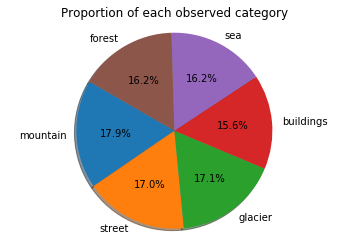

In [16]:
# Plot a pie chart
sizes = np.bincount(train_labels)
explode = (0, 0, 0, 0, 0, 0)  
plt.pie(sizes, explode=explode, labels=class_names,
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Proportion of each observed category')

plt.show()

In [17]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

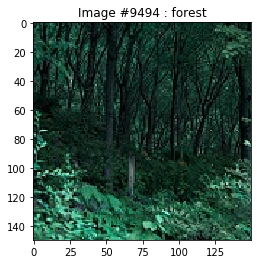

In [18]:
index = np.random.randint(train_images.shape[0])
plt.figure()
plt.imshow(train_images[index])
plt.grid(False)
plt.title('Image #{} : '.format(index) + class_names[train_labels[index]])
plt.show()

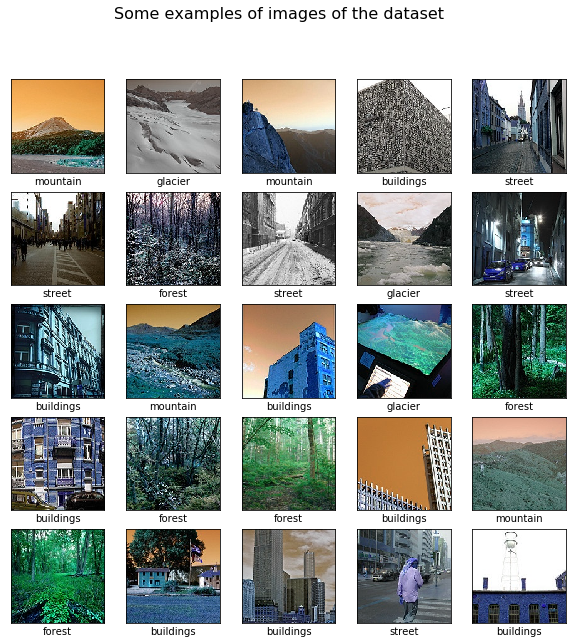

In [19]:
fig = plt.figure(figsize=(10,10))
fig.suptitle("Some examples of images of the dataset", fontsize=16)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), # the nn will learn the good filter to use
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

Optimizer: Pass it optimizer instances from the tf.keras.optimizers module, such as tf.keras.optimizers.Adam or tf.keras.optimizers.SGD or just strings such as 'sgd' and 'adam'

Loss: Loss function to optimize. Values include sparse_categorical_crossentropy, categorical_crossentropy, and binary_crossentropy

Metrics: Other options are Mean, MAE and MeanSquaredError

In [32]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/10
11227/11227 [==============================] - 158s 14ms/sample - loss: 1.1133 - acc: 0.5813 - val_loss: 0.8127 - val_acc: 0.7000
Epoch 2/10
11227/11227 [==============================] - 122s 11ms/sample - loss: 0.7084 - acc: 0.7489 - val_loss: 0.7015 - val_acc: 0.7421
Epoch 3/10
11227/11227 [==============================] - 139s 12ms/sample - loss: 0.5099 - acc: 0.8210 - val_loss: 0.7345 - val_acc: 0.7317
Epoch 4/10
11227/11227 [==============================] - 117s 10ms/sample - loss: 0.3774 - acc: 0.8696 - val_loss: 0.7548 - val_acc: 0.7260
Epoch 5/10
11227/11227 [==============================] - 142s 13ms/sample - loss: 0.2618 - acc: 0.9135 - val_loss: 0.6103 - val_acc: 0.7873
Epoch 6/10
11227/11227 [==============================] - 139s 12ms/sample - loss: 0.1407 - acc: 0.9591 - val_loss: 0.6982 - val_acc: 0.7788
Epoch 7/10
11227/11227 [==============================] - 127s 11ms/sample - loss: 0.0954 - acc: 0.9755 -

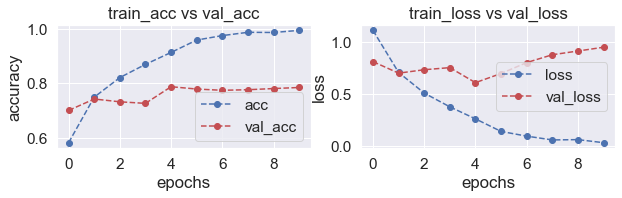

In [34]:
fig = plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(history.history['acc'],'bo--', label = "acc")
plt.plot(history.history['val_acc'], 'ro--', label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

plt.subplot(222)
plt.plot(history.history['loss'],'bo--', label = "loss")
plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
plt.title("train_loss vs val_loss")
plt.ylabel("loss")
plt.xlabel("epochs")


plt.legend()
plt.show()

In [35]:
test_loss = model.evaluate(test_images, test_labels)
print('test loss, test acc:'+str(test_loss))

3000/3000 [==============================] - 10s 3ms/sample - loss: 0.9680 - acc: 0.7747
test loss, test acc:[0.9679734525680542, 0.77466667]


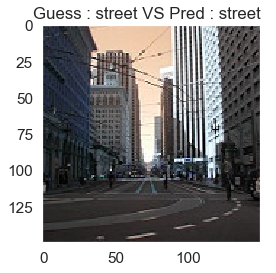

In [36]:
index = np.random.randint(test_images.shape[0]) # We choose a random index

img = (np.expand_dims(test_images[index], 0))
predictions = model.predict(img)     # Vector of probabilities
pred_img = np.argmax(predictions[0]) # We take the highest probability
pred_label = class_names[pred_img]
true_label = class_names[test_labels[index]] 

title = 'Guess : {} VS Pred : {}  '.format(pred_label , true_label )

plt.figure()
plt.imshow(test_images[index])
plt.grid(False)
plt.title(title)
plt.show()

In [37]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of mislabeled images by the classifier:", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mislabeled_images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[mislabeled_labels[i]])
    plt.show()

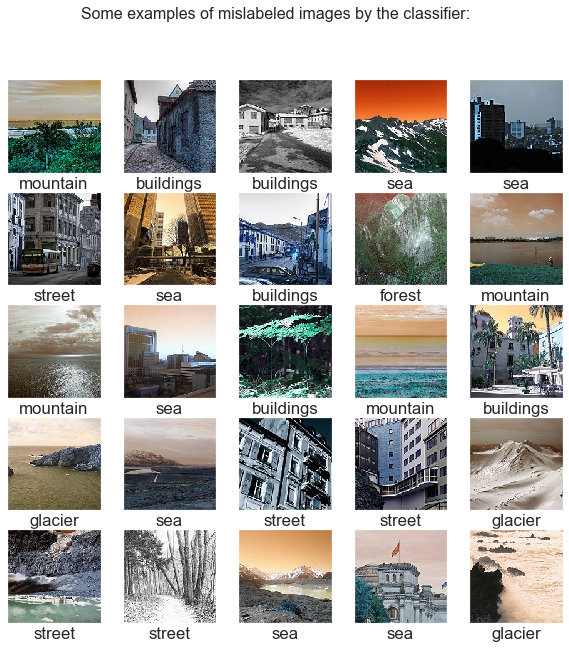

In [38]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

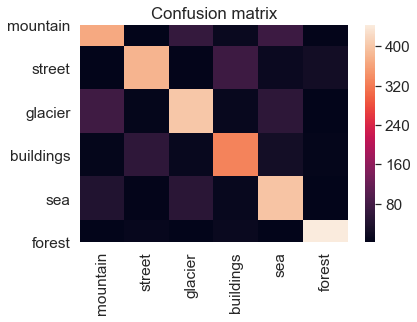

In [39]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.set(font_scale=1.4)
sn.heatmap(CM, annot=False,annot_kws={"size": 16},  xticklabels=class_names, yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

References:
1. Logistic Regression: https://www.coursera.org/learn/neural-networks-deep-learning/programming/XaIWT/logistic-regression-with-a-neural-network-mindset
2. Keras Implementation - https://www.tensorflow.org/guide/keras/overview and various online resources